In [2]:
import sys
import os

os.chdir("../")
from core.raft_stereo_fusion import RAFTStereoFusion
from train_fusion.dataloader import StereoDataset

import torch
from torch import nn
import numpy as np
from torch.utils.data import DataLoader
args = type("", (), {})()


#################################################
args.restore_ckpt = "models/raftstereo-realtime.pth"
#################################################
#################################################
#################################################

args.hidden_dims = [128, 128, 128]
args.corr_levels = 4
args.corr_radius = 4
args.n_downsample = 3
args.context_norm = "batch"
args.n_gru_layers = 2
args.shared_backbone = True
args.mixed_precision = True
args.corr_implementation = "reg_cuda"
args.slow_fast_gru = False


args.lr = 0.001
args.train_iters = 7
args.wdecay = 0.0001
args.num_steps = 100000
args.name = "StereoFusion"
args.batch_size = 4
args.fusion = "AFF"

model = nn.DataParallel(RAFTStereoFusion(args)).cuda()

model.load_state_dict(torch.load(args.restore_ckpt), strict=False)
model = model
model.train()

DataParallel(
  (module): RAFTStereoFusion(
    (cnet): FusionMultiBasicEncoder(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (relu1): ReLU(inplace=True)
      (layer1): Sequential(
        (0): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
    

In [10]:
train_loader = DataLoader(StereoDataset("/bean/depth"), batch_size=args.batch_size, shuffle=True, num_workers=4)

In [8]:
from tqdm.notebook import tqdm
from train_fusion.train import train, self_supervised_real_batch, flow_gt_batch
from train_fusion.loss_function import self_supervised_loss, self_fm_loss, gt_loss
train(args, model, train_loader, tqdm, self_supervised_real_batch, self_supervised_loss)

2024-08-09 10:39:14.477997: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 10:39:14.528906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 10:39:14.528935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 10:39:14.530546: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 10:39:14.542914: I tensorflow/core/platform/cpu_feature_guar

  0%|          | 0/4400 [00:00<?, ?it/s]

Batch 0 Loss 125.31527709960938


/home/jinnyeong/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Batch 1 Loss 102.24592590332031
Batch 2 Loss 112.76371002197266
Batch 3 Loss 155.6619110107422
Batch 4 Loss 109.3111801147461
Batch 5 Loss 127.0895767211914
Batch 6 Loss 77.28962707519531
Batch 7 Loss 124.61905670166016
Batch 8 Loss 121.50172424316406
Batch 9 Loss 105.87948608398438
Batch 10 Loss 110.02963256835938
Batch 11 Loss 108.35015106201172
Batch 12 Loss 94.66505432128906
Batch 13 Loss 34.02396774291992
Batch 14 Loss 78.15091705322266
Batch 15 Loss 85.8875503540039
Batch 16 Loss 42.383583068847656
Batch 17 Loss 80.32361602783203
Batch 18 Loss 52.65060043334961
Batch 19 Loss 61.137115478515625
Batch 20 Loss 58.672725677490234
Batch 21 Loss 47.160606384277344
Batch 22 Loss 51.425235748291016
Batch 23 Loss 34.22150421142578
Batch 24 Loss 49.51692199707031
Batch 25 Loss 46.258087158203125
Batch 26 Loss 45.510894775390625
Batch 27 Loss 35.34538269042969
Batch 28 Loss 29.60409927368164
Batch 29 Loss 37.899986267089844
Batch 30 Loss 26.712223052978516
Batch 31 Loss 39.941856384277344
B

KeyboardInterrupt: 

[('/bean/depth/08-01-19-37-50/19_37_56_237/rgb/left.png', '/bean/depth/08-01-19-37-50/19_37_57_937/rgb/left.png', '/bean/depth/08-01-19-37-50/19_38_03_737/rgb/left.png', '/bean/depth/08-01-19-37-50/19_37_53_537/rgb/left.png'), ('/bean/depth/08-01-19-37-50/19_37_56_237/rgb/right.png', '/bean/depth/08-01-19-37-50/19_37_57_937/rgb/right.png', '/bean/depth/08-01-19-37-50/19_38_03_737/rgb/right.png', '/bean/depth/08-01-19-37-50/19_37_53_537/rgb/right.png'), ('/bean/depth/08-01-19-37-50/19_37_56_237/nir/left.png', '/bean/depth/08-01-19-37-50/19_37_57_937/nir/left.png', '/bean/depth/08-01-19-37-50/19_38_03_737/nir/left.png', '/bean/depth/08-01-19-37-50/19_37_53_537/nir/left.png'), ('/bean/depth/08-01-19-37-50/19_37_56_237/nir/right.png', '/bean/depth/08-01-19-37-50/19_37_57_937/nir/right.png', '/bean/depth/08-01-19-37-50/19_38_03_737/nir/right.png', '/bean/depth/08-01-19-37-50/19_37_53_537/nir/right.png'), ('/bean/depth/08-01-19-37-50/19_37_56_237/rgb/disparity.png', '/bean/depth/08-01-19-37-

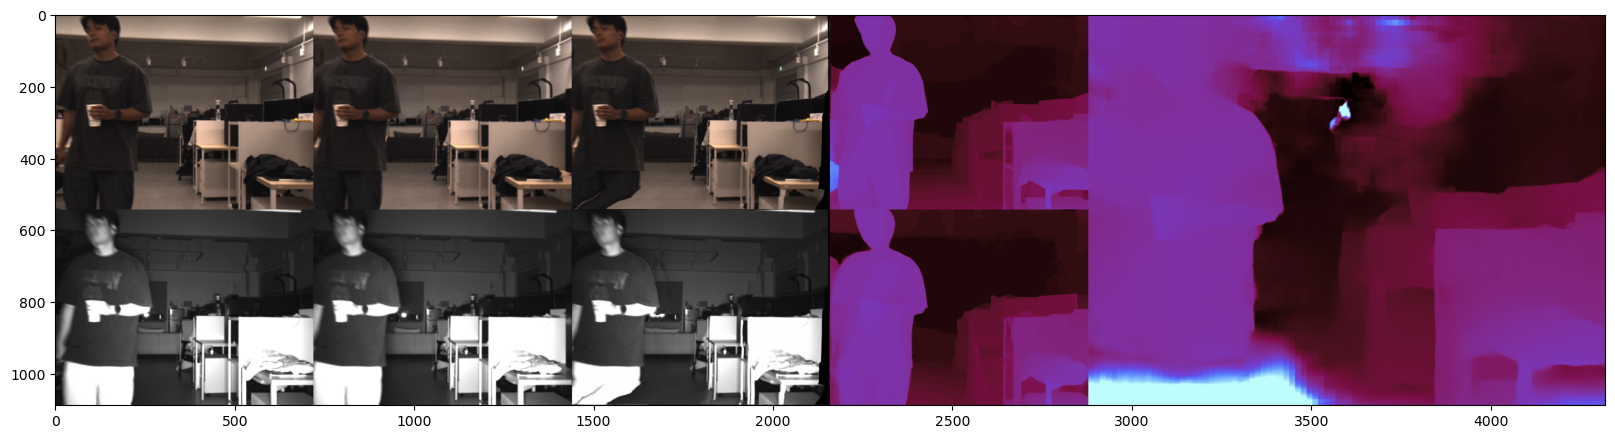

In [14]:
from core.utils.utils import InputPadder
import cv2
from train_fusion.loss_function import warp_reproject_loss, reproject_disparity
iterator = iter(train_loader)
inputs = next(iterator)
image0, image1, image2, image3, dis1, dis2 = [x.cuda() for x in inputs[1:]]
padder = InputPadder((540, 720), divis_by=16)
image0, image1, image2, image3, dis1, dis2 = padder.pad(image0, image1, image2, image3, dis1, dis2)
with torch.no_grad():
    _, flow = model(
            {
                "image_viz_left": image0,
                "image_viz_right": image1,
                "image_nir_left": image2,
                "image_nir_right": image3,
                "iters": args.train_iters,
                "test_mode": True,
                "flow_init": None,
                "heuristic_nir": False,
            }
        )
print(inputs[0])




print(image0.shape, flow.shape)
reprojected_right = reproject_disparity(flow, image0)
reprojected_right_nir = reproject_disparity(flow, image2)


disparity = -(flow.cpu().numpy())[0][0]



print(disparity.min(), disparity.max(), np.median(disparity))

disparity_max = 64

disparity = np.clip(disparity, 0, disparity_max)

disparity_color = cv2.applyColorMap(np.clip(disparity/disparity_max*255,0,255).astype(np.uint8), cv2.COLORMAP_MAGMA)



import matplotlib.pyplot as plt
image_left = image0[0].cpu().numpy().transpose(1, 2, 0).astype(np.uint8)
image_right = image1[0].cpu().numpy().transpose(1, 2, 0).astype(np.uint8)
image_right_re = reprojected_right[0].cpu().numpy().transpose(1, 2, 0).astype(np.uint8)
#image_disparity_single = inputs[0][0][0].replace("left","disparity_color")

image_nir_left = image2[0].cpu().numpy().transpose(1, 2, 0).astype(np.uint8)

image_nir_right = image3[0].cpu().numpy().transpose(1, 2, 0).astype(np.uint8)

image_nir_right_re = reprojected_right_nir[0].cpu().numpy().transpose(1, 2, 0).astype(np.uint8)
if image_nir_right.shape[2] == 1:
    image_nir_right = cv2.cvtColor(image_nir_right, cv2.COLOR_GRAY2BGR)
    image_nir_left = cv2.cvtColor(image_nir_left, cv2.COLOR_GRAY2BGR)
    image_nir_right_re = cv2.cvtColor(image_nir_right_re, cv2.COLOR_GRAY2BGR)

dis1 = dis1[0].cpu().numpy().transpose(1, 2, 0)
dis2 = dis2[0].cpu().numpy().transpose(1, 2, 0)

dis1 = cv2.applyColorMap(np.clip(dis1/disparity_max*255,0,255).astype(np.uint8), cv2.COLORMAP_MAGMA)
dis2 = cv2.applyColorMap(np.clip(dis2/disparity_max*255,0,255).astype(np.uint8), cv2.COLORMAP_MAGMA)

rgb_plot = np.concatenate([image_left, image_right, image_right_re, dis1], axis=1)
nir_plot = np.concatenate([image_nir_left, image_nir_right, image_nir_right_re, dis2], axis=1)
plot_input = np.concatenate([rgb_plot, nir_plot], axis=0)
fig = plt.figure(figsize=(20, 20))
subplot = fig.add_subplot(1, 1, 1)
subplot.imshow(np.concatenate([plot_input, cv2.resize(disparity_color, (image_left.shape[1]*2, image_left.shape[0]*2))], axis=1))